In [16]:
%load_ext autoreload
%autoreload 2

# load new frame-set

from repos.pyjunk.junktools.frameset import frameset

#frameset_res_low = 64

g_fVerbose = False
g_fJITLoading = True
frameset_res_low = 256
frameset_res_high = 1024
res_factor = frameset_res_high // frameset_res_low
strFramesetBaseName = 'wr_210604_16MSAA'
strFramesetName_low = strFramesetBaseName + '_' + str(frameset_res_low) + "_center"
strFramesetName_high = strFramesetBaseName + '_' + str(frameset_res_high) + "_center"
img_size = 32
batch_size = 128
test_batch_size = 128
num_frames = None
#start_frame = None
#num_frames = 4900
num_frames = 100

strDate = "210624"
strCheckpointName = "SSUNet_checkpoint" + '_' + str(frameset_res_low) + '_' + str(frameset_res_high) + "_" + strDate + ".tar"
print(strCheckpointName)

strTestFileName = "SSUNet"

frameset_low_res = frameset(strFramesetName_low, num_frames=num_frames, fJITLoading=g_fJITLoading, fVerbose=g_fVerbose)
frameset_low_res.Print()

frameset_high_res = frameset(strFramesetName_high, num_frames=num_frames, fJITLoading=g_fJITLoading, fVerbose=g_fVerbose)
frameset_high_res.Print()

# Split up into RGB and respective target framesets
frameset_low_res_rgbd = frameset(
    sourceFrameset=frameset_low_res, 
    strNewFramesetName=strFramesetBaseName + "_low_res_rgbd", 
    sourceChannels=[
        'Color',
        'RGBDepth'
    ]
)

frameset_high_res_rgb = frameset(
    sourceFrameset=frameset_high_res, 
    strNewFramesetName=strFramesetBaseName + "_high_res_rgb", 
    sourceChannels=['Color']
)

frameset_low_res_rgbd.Print()
#frameset_low_res_rgb[0].visualize()

frameset_high_res_rgb.Print()
#frameset_high_res_rgb[0].visualize()

# split into train and test

frameset_low_res_rgbd_train, frameset_low_res_rgbd_test = frameset_low_res_rgbd.split_into_train_and_test(0.8)
print(frameset_low_res_rgbd_train.shape())
print(frameset_low_res_rgbd_train.shape())
train_idx = frameset_low_res_rgbd_train.get_frame_ids()
test_idx = frameset_low_res_rgbd_test.get_frame_ids()

frameset_high_res_rgb_train, frameset_high_res_rgb_test = frameset_high_res_rgb.split_into_train_and_test(train_indices=train_idx, test_indices=test_idx)
print(frameset_high_res_rgb_train.shape())
print(frameset_high_res_rgb_test.shape())

# Confirm the match-up
frameset_low_res_rgbd_train[3].visualize()
frameset_high_res_rgb_train[3].visualize()
print(frameset_high_res_rgb_train[0].GetNumpyBuffer().shape)

frameset_low_res_rgbd_test[1].visualize()
frameset_high_res_rgb_test[1].visualize()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
SSUNet_checkpoint_256_1024_210624.tar
Loading frames 10 to 110


frame:   0%|          | 0/100 [00:00<?, ?it/s]

Frameset: wr_210604_16MSAA_256_center, 100 frames with 7 channels JIT enabled
Loading frames 10 to 110


frame:   0%|          | 0/100 [00:00<?, ?it/s]

Frameset: wr_210604_16MSAA_1024_center, 100 frames with 7 channels JIT enabled
Frameset: wr_210604_16MSAA_low_res_rgbd, 100 frames with 2 channels JIT enabled
Frameset: wr_210604_16MSAA_high_res_rgb, 100 frames with 1 channels JIT enabled
(80, 256, 256, 6)
(80, 256, 256, 6)


IndexError: list index out of range

In [ ]:
frameset_low_res_rgbd_train[3].visualize(fInvert=False)
#frameset_high_res_rgb_train[10].visualize()

In [11]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn

# Conv U-Net

from repos.pyjunk.models.Model import Model
from repos.pyjunk.models.SupersamplingUNet.SupersamplingUNet import SupersamplingUNet
from repos.pyjunk.junktools.frameset import frameset
from repos.pyjunk.solvers.ConvUNetTorchSolver import ConvUNetTorchSolver

import repos.pyjunk.junktools.pytorch_utils as ptu
ptu.SetGPUMode(False)

# TODO: Add the depth channel to input bruv

# Set up model
num_low_rgbd, H_low_rgbd, W_low_rgbd, C_low_rgbd = frameset_low_res_rgbd_train.shape()
num_high_rgb, H_high_rgb, W_high_rgb, C_high_rgb = frameset_high_res_rgb_train.shape()

batch_size = 2
num_patches = 2
lr_patch_size = (64, 64)
test_batch_size = 1

print("input dims: %d, %d, %d" % (H_low_rgbd, W_low_rgbd, C_low_rgbd))
print("target dims: %d, %d, %d" % (H_high_rgb, W_high_rgb, C_high_rgb))

scale_factor = H_high_rgb // H_low_rgbd
hr_patch_size = (lr_patch_size[0] * scale_factor, lr_patch_size[1] * scale_factor)
print(hr_patch_size)

modelSSUNet = SupersamplingUNet(
    input_rgb_shape=(H_low_rgbd, W_low_rgbd, 3),
    input_depth_shape=(H_low_rgbd, W_low_rgbd, 3),
    output_shape=(H_high_rgb, W_high_rgb, C_high_rgb),
    scale=4, 
    num_filters=32,
    ssim_window_size=11,
    lambda_augment = 0.001,
    lambda_vgg=0.1, 
    prob_aug_noise=0.2,
    upsample_mode='nearest',
    fZeroSampling=True,
    fLearnedMask=False,
    fAugmentNoise=True,
)

# # Test model
# npFrameBuffer = frameset_low_res_rgbd_train[0].GetNumpyBuffer()
# torchImageBuffer = torch.FloatTensor(npFrameBuffer)
# torchImageBuffer = torchImageBuffer.unsqueeze(0).to(ptu.GetDevice())
# print(torchImageBuffer.shape)
# #torchImageBuffer = torchImageBuffer.permute(0, 3, 1, 2)
# out = modelSSUNet.forward(torchImageBuffer)

# # #Test model loss
# # frameid = 3
# # npFrameBuffer = frameset_low_res_rgbd_train[frameid].GetNumpyBuffer()
# # torchImageBuffer = torch.FloatTensor(npFrameBuffer).to(ptu.GetDevice())
# # torchImageBuffer = torchImageBuffer.unsqueeze(0).to(ptu.GetDevice())

# # npTargetFrameBuffer = frameset_high_res_rgb_train[frameid].GetNumpyBuffer()
# # print(npTargetFrameBuffer.shape)
# # #frameset_high_res_rgb_train[frameid].visualize()
# # torchTargetImageBuffer = torch.FloatTensor(npTargetFrameBuffer)
# # torchTargetImageBuffer = torchTargetImageBuffer.unsqueeze(0).to(ptu.GetDevice())

# # loss = modelSSUNet.loss(torchImageBuffer, torchTargetImageBuffer)
# # print(loss)

# Set up the solver
dictSolverParams = {
    'lr': 1e-4,
    'epochs': 10000,
    'strOptimizer': 'Adam',
    'batch_size': batch_size,
    'test_batch_size': test_batch_size,
    'checkpoint_file_name': strCheckpointName,
    'checkpoint_epochs': 2,
    'save_test_file_name': strTestFileName,
    'num_patches': num_patches,
    'lr_patch_size': lr_patch_size,
    'scale_factor': scale_factor
}

# Train on frameset 
solver = ConvUNetTorchSolver(modelSSUNet, dictSolverParams)
# solver.train_frameset_and_plot_losses(
#     train_frameset=frameset_low_res_rgbd_train, train_target_frameset=frameset_high_res_rgb_train,
#     test_frameset=frameset_low_res_rgbd_test, test_target_frameset=frameset_high_res_rgb_test,
#     fVerbose=True)




The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
input dims: 256, 256, 6
target dims: 1024, 1024, 3
(256, 256)
(256, 256, 6)
14
enc first: 14 - 32
enc inner: 32 - 64
enc final: 64 - 128
dec first: 128 - 64
dec inner: 128 - 64 - 32
dec final: 64 - 32 - 3


In [ ]:
import torch

#strCheckpoint = "SSUNet_checkpoint.tar"

solver.SaveCheckpoint(strCheckpoint, 0, 0)

In [ ]:
import torch

#strCheckpoint = "SSUNet_checkpoint.tar"
strCheckpoint = "SSUNet_checkpoint_256_1024_210605.tar"

solver.LoadCheckpoint(strCheckpoint)

In [12]:
import torch

# dictSolverParams = {
#     'lr': 1e-4,
#     'epochs': 1000,
#     'strOptimizer': 'Adam',
#     'batch_size': batch_size,
#     'test_batch_size': test_batch_size
# }

# Lets target the normals bruv
solver.train_frameset_and_plot_losses(
    train_frameset=frameset_low_res_rgbd_train, train_target_frameset=frameset_high_res_rgb_train,
    test_frameset=frameset_low_res_rgbd_test, test_target_frameset=frameset_high_res_rgb_test,
    fVerbose=True)

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch 0


loading frame:   0%|          | 0/2 [00:00<?, ?it/s]

[]
[]


testing on frame:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 1


loading frame:   0%|          | 0/2 [00:00<?, ?it/s]

[]
[]


testing on frame:   0%|          | 0/1 [00:00<?, ?it/s]

epoch 2


loading frame:   0%|          | 0/2 [00:00<?, ?it/s]

[]
[]


KeyboardInterrupt: 

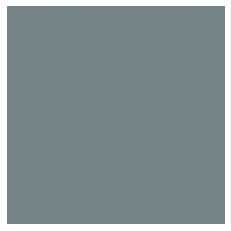

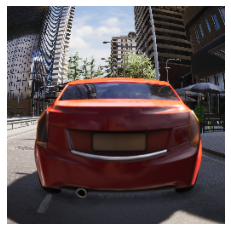

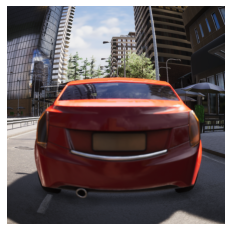

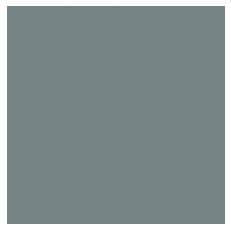

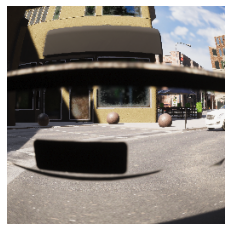

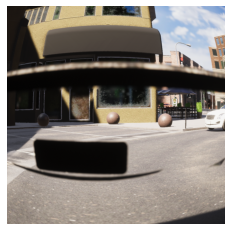

In [8]:
import random
n_frames = 2
#ex_output = None
lr_patch_size = None
lr_patch_size = (64, 64)


for n in range(n_frames):
    frameid = random.randint(0, frameset_low_res_rgbd_test.num_frames - 1)

    # test the forward pass
    #fwdPassImg, ex_output = modelSSUNet.forward_with_frame(frameset_low_res_rgbd_test[frameid])
    fwdPassImg, _ = modelSSUNet.forward_with_frame(frameset_low_res_rgbd_test[frameid], lr_patch_size=lr_patch_size)
    fwdPassImg.visualize()
    frameset_low_res_rgbd_test[frameid]['color'].visualize()
    frameset_high_res_rgb_test[frameid]['color'].visualize()

# # test the forward pass
# fwdPassImg = modelConvUNet.forward_with_frame(primitives_low_res_rgb_test[frameid])
# fwdPassImg.visualize()
# primitives_low_res_rgb_test[frameid].visualize()
# primitives_low_res_id_test[frameid].visualize()

In [ ]:
import os
import random

strONNXCheckpoint = os.path.splitext(strCheckpoint)[0] + ".onnx"
frameid = random.randint(0, frameset_low_res_rgbd_test.num_frames - 1)

in_rgb_C = 3
in_depth_C = 3

# Use a test frame as a sample input
npFrameBuffer = frameset_low_res_rgbd_test[frameid].GetNumpyBuffer()
torchImageBuffer = torch.FloatTensor(npFrameBuffer)
torchImageBuffer = torchImageBuffer.unsqueeze(0).to(ptu.GetDevice())
torchImageBufferInput = torchImageBuffer[:, :, :, :(in_rgb_C + in_depth_C)]
torchImageBufferRGB = torchImageBuffer[:, :, :, :3]
torchImageBufferRGBDepth = torchImageBuffer[:, :, :, 3:6]
torchImageBufferInput = torchImageBufferInput.permute(0, 3, 1, 2)
#print(torchImageBuffer.shape)
#print(ex_output.shape)

dynamic_axes={
    'in_x': {
        0 : 'batch_size',
    },
    'out':
    {
        0 : 'batch_size'
    }
}

#input_tuple = (torchImageBufferRGB, torchImageBufferRGBDepth)

params_for_forward = {
    'type': 'ycbcrd'
}

solver.SaveONNXCheckpoint(strONNXCheckpoint, 
                          #input_tuple,
                          torchImageBufferInput,
                          #input_names=['in_x_rgb', 'in_x_depth'],
                          input_names=['in_x'],
                          output_names=['out_rgb'],
                          opset_version=11, 
                          #example_outputs=(ex_output),
                          dynamic_axes=dynamic_axes,
                          params_for_forward=params_for_forward)

In [ ]:
import onnx

# Load the ONNX model
onnxModel = onnx.load(strONNXCheckpoint)

# Check that the IR is well formed
onnx.checker.check_model(onnxModel)

# Print a human readable representation of the graph
onnx.helper.printable_graph(onnxModel.graph)